<a href="https://colab.research.google.com/github/ritwiks9635/Segmentation-Model/blob/main/Image_Segmentation_using_FC_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Image Segmentation using FC Network***

## Introduction

The following example walks through the steps to implement Fully-Convolutional Networks
for Image Segmentation on the Oxford-IIIT Pets dataset.
The model was proposed in the paper,
[Fully Convolutional Networks for Semantic Segmentation by Long et. al.(2014)](https://arxiv.org/abs/1411.4038).
Image segmentation is one of the most common and introductory tasks when it comes to
Computer Vision, where we extend the problem of Image Classification from
one-label-per-image to a pixel-wise classification problem.
In this example, we will assemble the aforementioned Fully-Convolutional Segmentation architecture,
capable of performing Image Segmentation.
The network extends the pooling layer outputs from the VGG in order to perform upsampling
and get a final result. The intermediate outputs coming from the 3rd, 4th and 5th Max-Pooling layers from VGG19 are
extracted out and upsampled at different levels and factors to get a final output with the same shape as that
of the output, but with the class of each pixel present at each location, instead of pixel intensity values.
Different intermediate pool layers are extracted and processed upon for different versions of the network.
The FCN architecture has 3 versions of differing quality.

- FCN-32S
- FCN-16S
- FCN-8S

All versions of the model derive their outputs through an iterative processing of
successive intermediate pool layers of the main backbone used.
A better idea can be gained from the figure below.

| ![FCN Architecture](https://i.imgur.com/Ttros06.png) |
| :--: |
| **Diagram 1**: Combined Architecture Versions (Source: Paper) |

To get a better idea on Image Segmentation or find more pre-trained models, feel free to
navigate to the [Hugging Face Image Segmentation Models](https://huggingface.co/models?pipeline_tag=image-segmentation) page,
or a [PyImageSearch Blog on Semantic Segmentation](https://pyimagesearch.com/2018/09/03/semantic-segmentation-with-opencv-and-deep-learning/)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
os.environ["KERAS_BACKEND"] = "tensorflow"

## Set configurations for notebook variables

We set the required parameters for the experiment.
The chosen dataset has a total of 4 classes per image, with regards to the segmentation mask.
We also set our hyperparameters in this cell.

Mixed Precision as an option is also available in systems which support it, to reduce
load.
This would make most tensors use `16-bit float` values instead of `32-bit float`
values, in places where it will not adversely affect computation.
This means, during computation, TensorFlow will use `16-bit float` Tensors to increase speed at the cost of precision,
while storing the values in their original default `32-bit float` form.

In [ ]:
num_classes = 4
img_size  = 224
batch_size = 32
auto = tf.data.AUTOTUNE

epochs = 20
learning_rate = 1e-3
weight_decay = 1e-4

MIXED_PRECISION = True
if MIXED_PRECISION:
    policy = keras.mixed_precision.Policy("mixed_float16")
    keras.mixed_precision.set_global_policy(policy)

In [ ]:
(train_ds, val_ds, test_ds) = tfds.load(
    "oxford_iiit_pet",
    split = ["train[:85%]", "train[85%:]", "test"],
    batch_size = batch_size,
    shuffle_files = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete64BUXG/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete64BUXG/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
train_ds

<_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>

In [ ]:
def prepare_data(datasets):
    image = datasets["image"]
    mask = datasets["segmentation_mask"]

    resize_ds = layers.Resizing(img_size, img_size)

    image = resize_ds(image)
    mask = resize_ds(mask)

    return image, mask

In [ ]:
train_ds = train_ds.map(prepare_data, num_parallel_calls = auto)
valid_ds = val_ds.map(prepare_data, num_parallel_calls = auto)
test_ds  = test_ds.map(prepare_data, num_parallel_calls = auto)

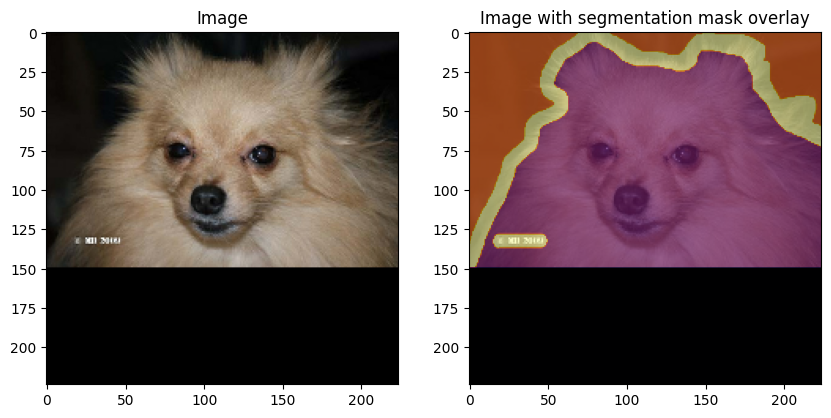

In [ ]:
image, mask = next(iter(test_ds))
random_idx = tf.random.uniform([], minval=0, maxval= batch_size, seed=10)

test_image = image[int(random_idx)].numpy().astype("float")
test_mask = mask[int(random_idx)].numpy().astype("float")

# Overlay segmentation mask on top of image.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].set_title("Image")
ax[0].imshow(test_image / 255.0)

ax[1].set_title("Image with segmentation mask overlay")
ax[1].imshow(test_image / 255.0)
ax[1].imshow(
    test_mask,
    cmap="inferno",
    alpha=0.6,
)
plt.show()

In [ ]:
def preprocess_data(image, mask):
    image = keras.applications.vgg19.preprocess_input(image)
    return image, mask

train_data = (
    train_ds.map(preprocess_data, num_parallel_calls = auto)
    .shuffle(buffer_size = 1024)
    .prefetch(buffer_size = 1024))

valid_data = (
    valid_ds.map(preprocess_data, num_parallel_calls = auto)
    .shuffle(buffer_size = 1024)
    .prefetch(buffer_size = 1024))

test_data = (
    test_ds.map(preprocess_data, num_parallel_calls = auto)
    .shuffle(buffer_size = 1024)
    .prefetch(buffer_size = 1024))

## Model Definition

The Fully-Convolutional Network boasts a simple architecture composed of only
`keras.layers.Conv2D` Layers, `keras.layers.Dense` layers and `keras.layers.Dropout`
layers.

| ![FCN Architecture](https://i.imgur.com/PerTKjf.png) |
| :--: |
| **Diagram 2**: Generic FCN Forward Pass (Source: Paper)|

Pixel-wise prediction is performed by having a Softmax Convolutional layer with the same
size of the image, such that we can perform direct comparison
We can find several important metrics such as Accuracy and Mean-Intersection-over-Union on the network.



### Backbone (VGG-19)

We use the [VGG-19 network](https://keras.io/api/applications/vgg/) as the backbone, as
the paper suggests it to be one of the most effective backbones for this network.
We extract different outputs from the network by making use of `keras.models.Model`.
Following this, we add layers on top to make a network perfectly simulating that of
Diagram 1.
The backbone's `keras.layers.Dense` layers will be converted to `keras.layers.Conv2D`
layers based on the [original Caffe code present here.](https://github.com/linxi159/FCN-caffe/blob/master/pascalcontext-fcn16s/net.py)
All 3 networks will share the same backbone weights, but will have differing results
based on their extensions.
We make the backbone non-trainable to improve training time requirements.
It is also noted in the paper that making the network trainable does not yield major benefits.

In [ ]:
inputs = keras.Input(shape = (img_size, img_size, 3))

vgg_model = keras.applications.VGG19(include_top = True, weights = "imagenet")

fcn_backbone = keras.Model(
    inputs = vgg_model.layers[1].input,
    outputs  = [vgg_model.get_layer(layer_name).output for layer_name in ["block3_pool", "block4_pool", "block5_pool"]])

fcn_backbone.trainable = False

x = fcn_backbone(inputs)

units = [4096, 4096]
dense_convs = []

for i in range(len(units)):
    dense_conv = layers.Conv2D(
        filters = units[i],
        kernel_size = (7, 7) if i == 0 else (1, 1),
        strides = (1, 1),
        padding = "same",
        activation = "relu",
        use_bias = False,
        kernel_initializer = keras.initializers.Constant(1.0))
    dense_convs.append(dense_conv)

    dropout = layers.Dropout(0.5)
    dense_convs.append(dropout)

dense_convs = keras.Sequential(dense_convs)
dense_convs.trainable = False

x[-1] = dense_convs(x[-1])

pool3_output, pool4_output,  pool5_output = x

574710816/574710816 [==============================] - 9s 0us/step


### FCN-32S

We extend the last output, perform a `1x1 Convolution` and perform 2D Bilinear Upsampling
by a factor of 32 to get an image of the same size as that of our input.
We use a simple `keras.layers.UpSampling2D` layer over a `keras.layers.Conv2DTranspose`
since it yields performance benefits from being a deterministic mathematical operation
over a Convolutional operation
It is also noted in the paper that making the Up-sampling parameters trainable does not yield benefits.
Original experiments of the paper used Upsampling as well.

In [ ]:
pool5 = layers.Conv2D(num_classes, kernel_size = (1, 1), strides = (1, 1), padding = "same", activation = "relu")

fcn32s_conv = layers.Conv2D(num_classes, kernel_size = (1, 1), padding = "same", strides = (1, 1), activation = "softmax")

fcn32s_upsampling = layers.UpSampling2D(size = (32, 32), data_format = keras.backend.image_data_format(), interpolation = "bilinear")

fcn32s_pool = pool5(pool5_output)
fcn32s_conv_la = fcn32s_conv(fcn32s_pool)
fcn32s_output = fcn32s_upsampling(fcn32s_conv_la)

fcn32s_model = keras.Model(inputs = inputs, outputs = fcn32s_output)

### FCN-16S

The pooling output from the FCN-32S is extended and added to the 4th-level Pooling output
of our backbone.
Following this, we upsample by a factor of 16 to get image of the same
size as that of our input.

In [ ]:
pool4 = layers.Conv2D(
    num_classes,
    kernel_size = (1, 1),
    strides = (1, 1),
    padding = "same",
    activation = "linear",
    kernel_initializer  = keras.initializers.Zeros())(pool4_output)

pool5 = layers.UpSampling2D(
    size = (2, 2),
    data_format = keras.backend.image_data_format(),
    interpolation = "bilinear")(fcn32s_pool)

fcn16s_pool = layers.Add()([pool4, pool5])

fcn16s_conv = layers.Conv2D(
    num_classes,
    kernel_size = (1, 1),
    strides = (1, 1),
    padding = "same",
    activation = "softmax")(fcn16s_pool)

fcn16s_upsample = layers.UpSampling2D(
    size = (16, 16),
    data_format = keras.backend.image_data_format(),
    interpolation = "bilinear")(fcn16s_conv)

fcn16s_model = keras.Model(inputs = inputs, outputs = fcn16s_upsample)

## FCN-8S

The pooling output from the FCN-16S is extended once more, and added from the 3rd-level
Pooling output of our backbone.
This result is upsampled by a factor of 8 to get an image of the same size as that of our input.

In [ ]:
pool3 = layers.Conv2D(
    num_classes,
    kernel_size = (1, 1),
    strides = (1, 1),
    padding = "same",
    activation = "linear",
    kernel_initializer  = keras.initializers.Zeros())(pool3_output)

pool_output = layers.UpSampling2D(
    size = (2, 2),
    data_format = keras.backend.image_data_format(),
    interpolation = "bilinear")(fcn16s_pool)

fcn8s_pool = layers.Add()([pool3, pool_output])

fcn8s_conv = layers.Conv2D(
    num_classes,
    kernel_size = (1, 1),
    strides = (1, 1),
    padding = "same",
    activation = "softmax")(fcn8s_pool)

fcn8s_upsample = layers.UpSampling2D(
    size = (8, 8),
    data_format = keras.backend.image_data_format(),
    interpolation = "bilinear")(fcn8s_conv)

fcn8s_model = keras.Model(inputs = inputs, outputs = fcn8s_upsample)

### Load weights into backbone

It was noted in the paper, as well as through experimentation that extracting the weights
of the last 2 Fully-connected Dense layers from the backbone, reshaping the weights to
fit that of the `keras.layers.Dense` layers we had previously converted into
`keras.layers.Conv2D`, and setting them to it yields far better results and a significant
increase in mIOU performance.

In [ ]:
# VGG's last 2 layers
weights1 = vgg_model.get_layer("fc1").get_weights()[0]
weights2 = vgg_model.get_layer("fc2").get_weights()[0]

weights1 = weights1.reshape(7, 7, 512, 4096)
weights2 = weights2.reshape(1, 1, 4096, 4096)

dense_convs.layers[0].set_weights([weights1])
dense_convs.layers[2].set_weights([weights2])

## Training

The original paper talks about making use of [SGD with Momentum](https://keras.io/api/optimizers/sgd/) as the optimizer of choice.
But it was noticed during experimentation that
[AdamW](https://keras.io/api/optimizers/adamw/)
yielded better results in terms of mIOU and Pixel-wise Accuracy.

In [ ]:
fcn32s_optimizer = keras.optimizers.AdamW(
    learning_rate = learning_rate, weight_decay = weight_decay
)

fcn32s_loss = keras.losses.SparseCategoricalCrossentropy()

# Maintain mIOU and Pixel-wise Accuracy as metrics
fcn32s_model.compile(
    optimizer=fcn32s_optimizer,
    loss=fcn32s_loss,
    metrics=[
        keras.metrics.MeanIoU(num_classes = num_classes, sparse_y_pred=False),
        keras.metrics.SparseCategoricalAccuracy(),
    ],
)

fcn32s_history = fcn32s_model.fit(train_data, epochs = epochs, validation_data=valid_data)

Epoch 1/20
98/98 [==============================] - 87s 351ms/step - loss: 1.0906 - mean_io_u: 0.2790 - sparse_categorical_accuracy: 0.5876 - val_loss: 0.9607 - val_mean_io_u: 0.3127 - val_sparse_categorical_accuracy: 0.6521
Epoch 2/20
98/98 [==============================] - 51s 192ms/step - loss: 0.8701 - mean_io_u: 0.3189 - sparse_categorical_accuracy: 0.6668 - val_loss: 0.8491 - val_mean_io_u: 0.3257 - val_sparse_categorical_accuracy: 0.6644
Epoch 3/20
98/98 [==============================] - 54s 232ms/step - loss: 0.7921 - mean_io_u: 0.3435 - sparse_categorical_accuracy: 0.6841 - val_loss: 0.7823 - val_mean_io_u: 0.3806 - val_sparse_categorical_accuracy: 0.6961
Epoch 4/20
98/98 [==============================] - 50s 189ms/step - loss: 0.7381 - mean_io_u: 0.3975 - sparse_categorical_accuracy: 0.7102 - val_loss: 0.7414 - val_mean_io_u: 0.4178 - val_sparse_categorical_accuracy: 0.7141
Epoch 5/20
98/98 [==============================] - 50s 191ms/step - loss: 0.6996 - mean_io_u: 0.411

In [ ]:
fcn16s_optimizer = keras.optimizers.AdamW(
    learning_rate = learning_rate, weight_decay = weight_decay
)

fcn16s_loss = keras.losses.SparseCategoricalCrossentropy()

# Maintain mIOU and Pixel-wise Accuracy as metrics
fcn16s_model.compile(
    optimizer=fcn16s_optimizer,
    loss=fcn16s_loss,
    metrics=[
        keras.metrics.MeanIoU(num_classes = num_classes, sparse_y_pred=False),
        keras.metrics.SparseCategoricalAccuracy(),
    ],
)

fcn16s_history = fcn16s_model.fit(train_data, epochs = epochs, validation_data=valid_data)

Epoch 1/20
98/98 [==============================] - 54s 202ms/step - loss: 3.7133 - mean_io_u_1: 0.3725 - sparse_categorical_accuracy: 0.7223 - val_loss: 3.9199 - val_mean_io_u_1: 0.3726 - val_sparse_categorical_accuracy: 0.7266
Epoch 2/20
98/98 [==============================] - 51s 201ms/step - loss: 3.5637 - mean_io_u_1: 0.3753 - sparse_categorical_accuracy: 0.7519 - val_loss: 3.8919 - val_mean_io_u_1: 0.3759 - val_sparse_categorical_accuracy: 0.7308
Epoch 3/20
98/98 [==============================] - 50s 197ms/step - loss: 3.5171 - mean_io_u_1: 0.3775 - sparse_categorical_accuracy: 0.7564 - val_loss: 3.8813 - val_mean_io_u_1: 0.3770 - val_sparse_categorical_accuracy: 0.7324
Epoch 4/20
98/98 [==============================] - 49s 200ms/step - loss: 3.5216 - mean_io_u_1: 0.3782 - sparse_categorical_accuracy: 0.7565 - val_loss: 3.8764 - val_mean_io_u_1: 0.3775 - val_sparse_categorical_accuracy: 0.7331
Epoch 5/20
98/98 [==============================] - 51s 202ms/step - loss: 3.5278 - 

In [ ]:
fcn8s_optimizer = keras.optimizers.AdamW(
    learning_rate = learning_rate, weight_decay = weight_decay
)

fcn8s_loss = keras.losses.SparseCategoricalCrossentropy()

# Maintain mIOU and Pixel-wise Accuracy as metrics
fcn8s_model.compile(
    optimizer=fcn8s_optimizer,
    loss=fcn8s_loss,
    metrics=[
        keras.metrics.MeanIoU(num_classes = num_classes, sparse_y_pred=False),
        keras.metrics.SparseCategoricalAccuracy(),
    ],
)

fcn8s_history = fcn8s_model.fit(train_data, epochs = epochs, validation_data=valid_data)

Epoch 1/20
98/98 [==============================] - 54s 209ms/step - loss: 4.6494 - mean_io_u_2: 0.3669 - sparse_categorical_accuracy: 0.6935 - val_loss: 3.8597 - val_mean_io_u_2: 0.3903 - val_sparse_categorical_accuracy: 0.7450
Epoch 2/20
98/98 [==============================] - 50s 202ms/step - loss: 3.5107 - mean_io_u_2: 0.3898 - sparse_categorical_accuracy: 0.7676 - val_loss: 3.8522 - val_mean_io_u_2: 0.3909 - val_sparse_categorical_accuracy: 0.7457
Epoch 3/20
98/98 [==============================] - 50s 202ms/step - loss: 3.5026 - mean_io_u_2: 0.3904 - sparse_categorical_accuracy: 0.7682 - val_loss: 3.8457 - val_mean_io_u_2: 0.3918 - val_sparse_categorical_accuracy: 0.7464
Epoch 4/20
98/98 [==============================] - 50s 200ms/step - loss: 3.5159 - mean_io_u_2: 0.3904 - sparse_categorical_accuracy: 0.7676 - val_loss: 3.8452 - val_mean_io_u_2: 0.3919 - val_sparse_categorical_accuracy: 0.7466
Epoch 5/20
98/98 [==============================] - 50s 202ms/step - loss: 3.4839 - 

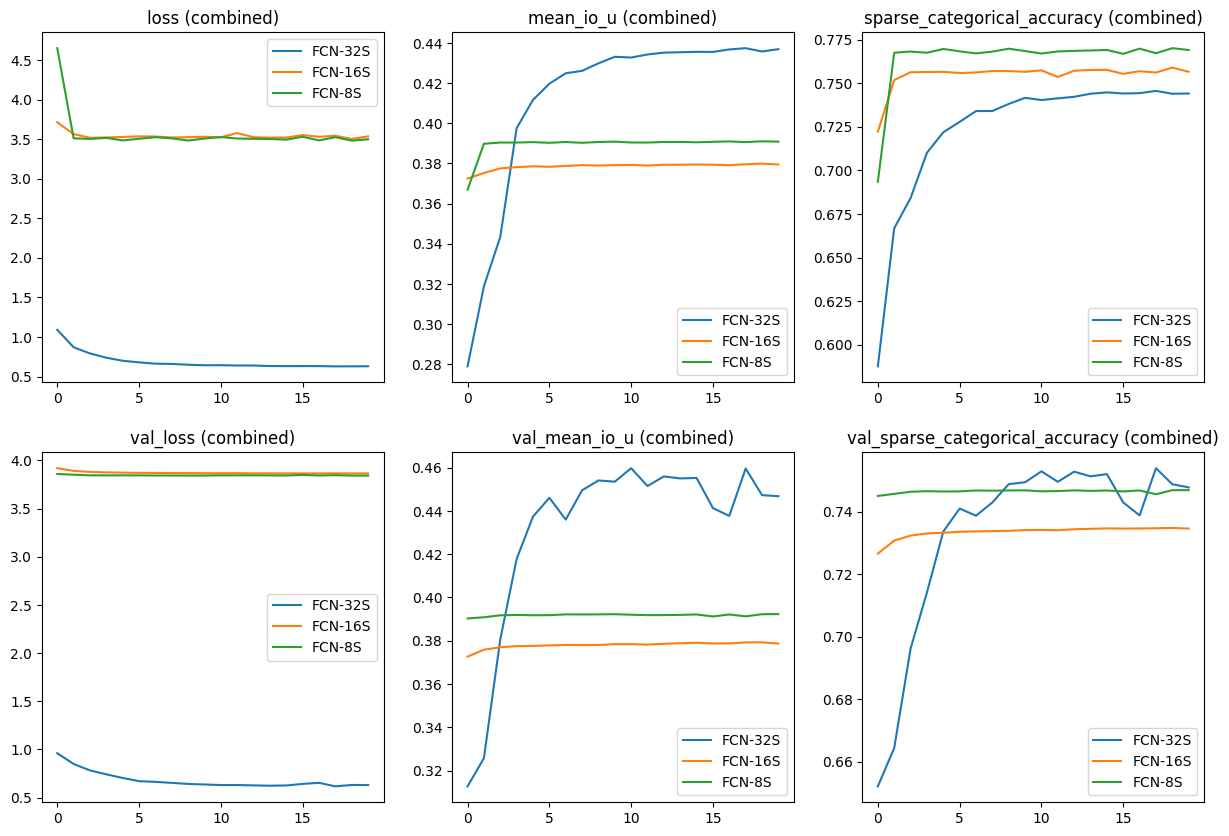

In [ ]:
total_plots = len(fcn32s_history.history)
cols = total_plots // 2

rows = total_plots // cols

if total_plots % cols != 0:
    rows += 1

# Set all history dictionary objects
fcn32s_dict = fcn32s_history.history
fcn16s_dict = fcn16s_history.history
fcn8s_dict = fcn8s_history.history

pos = range(1, total_plots + 1)
plt.figure(figsize=(15, 10))

for i, ((key_32s, value_32s), (key_16s, value_16s), (key_8s, value_8s)) in enumerate(
    zip(fcn32s_dict.items(), fcn16s_dict.items(), fcn8s_dict.items())
):
    plt.subplot(rows, cols, pos[i])
    plt.plot(range(len(value_32s)), value_32s)
    plt.plot(range(len(value_16s)), value_16s)
    plt.plot(range(len(value_8s)), value_8s)
    plt.title(str(key_32s) + " (combined)")
    plt.legend(["FCN-32S", "FCN-16S", "FCN-8S"])

plt.show()

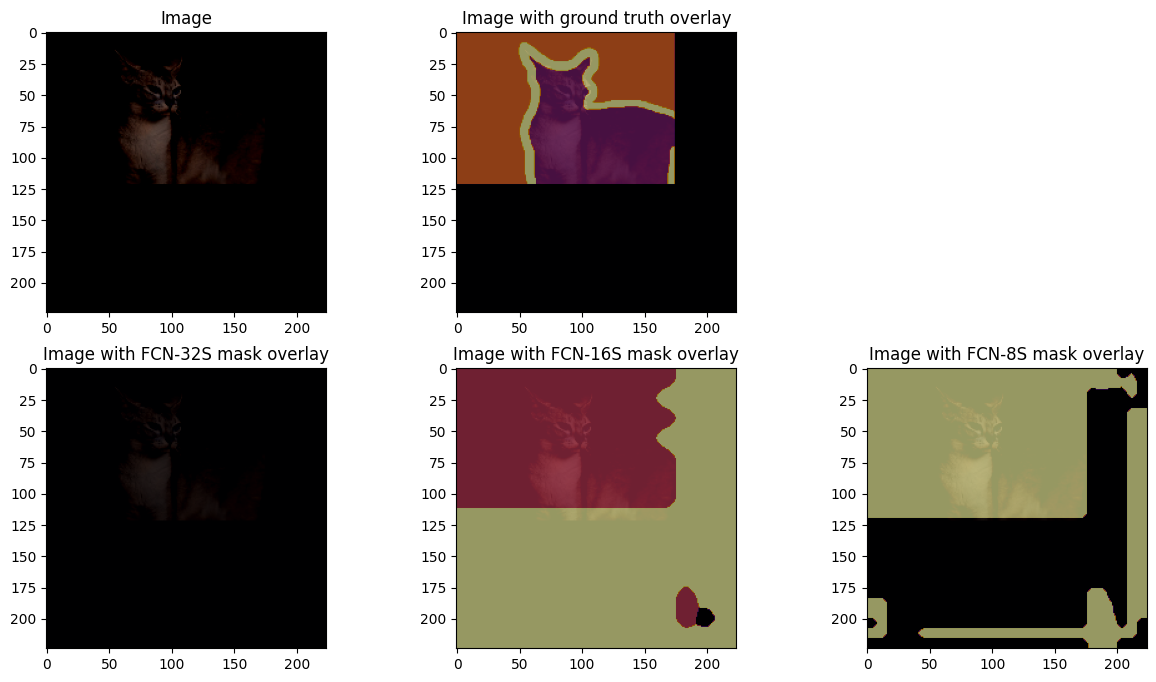

In [ ]:
images, masks = next(iter(test_data))
random_idx = tf.random.uniform([], minval=0, maxval= batch_size, seed=10)

# Get random test image and mask
test_image = images[int(random_idx)].numpy().astype("float")
test_mask = masks[int(random_idx)].numpy().astype("float")

pred_image = tf.expand_dims(test_image, axis=0)
pred_image = keras.applications.vgg19.preprocess_input(pred_image)

# Perform inference on FCN-32S
pred_mask_32s = fcn32s_model.predict(pred_image, verbose=0).astype("float")
pred_mask_32s = np.argmax(pred_mask_32s, axis=-1)
pred_mask_32s = pred_mask_32s[0, ...]

# Perform inference on FCN-16S
pred_mask_16s = fcn16s_model.predict(pred_image, verbose=0).astype("float")
pred_mask_16s = np.argmax(pred_mask_16s, axis=-1)
pred_mask_16s = pred_mask_16s[0, ...]

# Perform inference on FCN-8S
pred_mask_8s = fcn8s_model.predict(pred_image, verbose=0).astype("float")
pred_mask_8s = np.argmax(pred_mask_8s, axis=-1)
pred_mask_8s = pred_mask_8s[0, ...]

# Plot all results
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

fig.delaxes(ax[0, 2])

ax[0, 0].set_title("Image")
ax[0, 0].imshow(test_image / 255.0)

ax[0, 1].set_title("Image with ground truth overlay")
ax[0, 1].imshow(test_image / 255.0)
ax[0, 1].imshow(
    test_mask,
    cmap="inferno",
    alpha=0.6,
)

ax[1, 0].set_title("Image with FCN-32S mask overlay")
ax[1, 0].imshow(test_image / 255.0)
ax[1, 0].imshow(pred_mask_32s, cmap="inferno", alpha=0.6)

ax[1, 1].set_title("Image with FCN-16S mask overlay")
ax[1, 1].imshow(test_image / 255.0)
ax[1, 1].imshow(pred_mask_16s, cmap="inferno", alpha=0.6)

ax[1, 2].set_title("Image with FCN-8S mask overlay")
ax[1, 2].imshow(test_image / 255.0)
ax[1, 2].imshow(pred_mask_8s, cmap="inferno", alpha=0.6)

plt.show()